In [ ]:
# Core
import pandas as pd
import numpy as np
from pathlib import Path

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)

# Tracking
import mlflow

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [14]:
DATA_PATH = "../data/training/creditcard_prepared.csv"

df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (284807, 31)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount_scaled,Time_scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.124303,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-1.114639,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.682368,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.009339,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670241,-1.996541


In [15]:
class_counts = df["Class"].value_counts(normalize=True)
print(class_counts)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [16]:
X = df.drop("Class", axis=1)
y = df["Class"]

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (284807, 30)
Target shape: (284807,)


In [17]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,
    stratify=y,
    random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

Train size: (199364, 30)
Validation size: (42721, 30)
Test size: (42722, 30)


In [18]:
model = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [19]:
y_val_proba = model.predict_proba(X_val)[:, 1]
y_val_pred = model.predict(X_val)

In [20]:
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.06432160804020101
Recall: 0.8648648648648649


In [21]:
auprc = average_precision_score(y_val, y_val_proba)
print("Validation AUPRC:", auprc)

Validation AUPRC: 0.6264273450553833


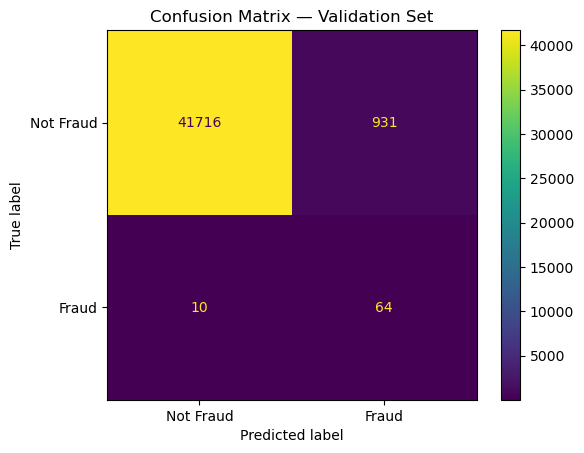

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay.from_predictions(
    y_val,
    y_val_pred,
    display_labels=["Not Fraud", "Fraud"],
    values_format="d"
)

plt.title("Confusion Matrix — Validation Set")
plt.show()

In [ ]:
mlruns_path = Path("../mlruns").resolve()
mlruns_path.mkdir(parents=True, exist_ok=True)

mlflow.set_tracking_uri(f"file:///{mlruns_path}")

mlflow.set_experiment("creditcard_fraud_detection")

with mlflow.start_run(run_name="baseline_logistic_regression"):

    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("max_iter", 1000)

    mlflow.log_metric("AUPRC_validation", auprc)
    mlflow.log_metric("precision_validation", precision)
    mlflow.log_metric("recall_validation", recall)